In [2]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray

In [3]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 10
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[bound*3:bound*4-1],
            1: devices[bound:bound*2-1],
            2: devices[bound*2+1:bound*3],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(80 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [4]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()
print(architecture.clusters)

for j in executions:
    architecture.heart_beat()
    for h in j:
        architecture.generate(h)
    # print(architecture.data_allocation)
    # print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

{0: [9, 10], 1: [3, 4], 2: [7, 8], 3: [0]}


In [5]:
class AcesStepArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity]
        self.quantity = 0
        self.last_call = [-1]
        self.weight = 0
        self.type = 0

        self.observation_space = Dict({
            "quantity": Discrete(maximum_data+1, start=0),
            "weight": Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-10, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)               # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        self.quantity = sum(self.architecture.data[type].values())
        self.weight = self.architecture.weights[type]
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)              # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "quantity": self.quantity,
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        cut_action = action[:self.quantity]
        latency = 0
        flag = False
        computed_latencies = 0              #CHANGEEEEEEEEEEEEEEE
        for location in cut_action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
            if self.free_space[location] <= self.max_free_space[location]*0.2:
                flag = True

        if flag:
            reward = -1
        else:
            reward = 1 - (latency / (computed_latencies * 22+1))             # CHANGEEEEEEEEEEEEEEEEEEEEEE

        if self.type == 3:
            done = True
        else:
            done = False
            self.type += 1

        info = {}

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [6]:
# ar = AcesStepArchitectureEnv(24)
# ar.reset()
ar.step(ar.action_space.sample())

NameError: name 'ar' is not defined

In [7]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(24)
check_env(EnvCompatibility(simulated_aces))

2023-06-12 00:12:49,417	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-12 00:12:49,419	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [ ]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(24)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]


algorithm_first = config.build()

result_first =[]

for j in tqdm(range(2500)):
    result_train = algorithm_first.train()["episode_reward_mean"]
    result_first.append(result_train)
    if (j%100 == 0):
        print(result_train)
print(result_first)

2023-06-12 00:13:46,000	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-12 00:13:59,647	INFO trainable.py:172 -- Trainable.setup took 15.656 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-12 00:13:59,651	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  0%|                                                                                                                                                                           | 1/2500 [00:12<8:36:27, 12.40s/it]

1.2069703802038392


  0%|▏                                                                                                                                                                          | 3/2500 [00:38<8:51:11, 12.76s/it]

In [ ]:
# for j in tqdm(range(100)):
#     result_train = algorithm_first.train()["episode_reward_mean"]
#     result_first.append(result_train)
#     if (j%20 == 0):
#         print(result_train)
# print(result_first)

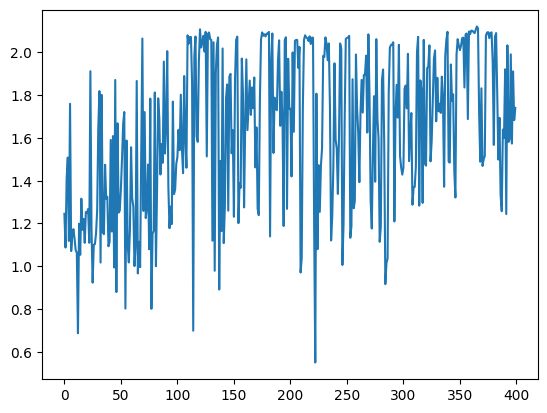

In [110]:
plt.plot(result_first)

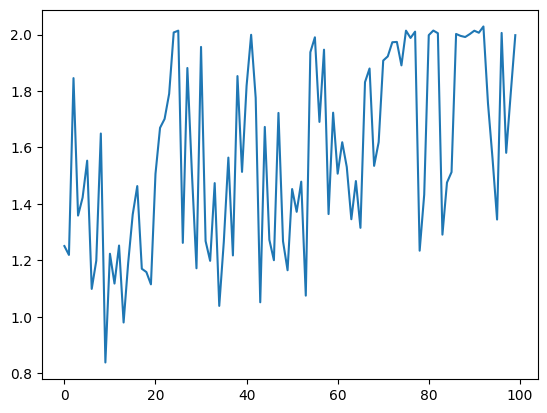

In [103]:
plt.plot(result_first)

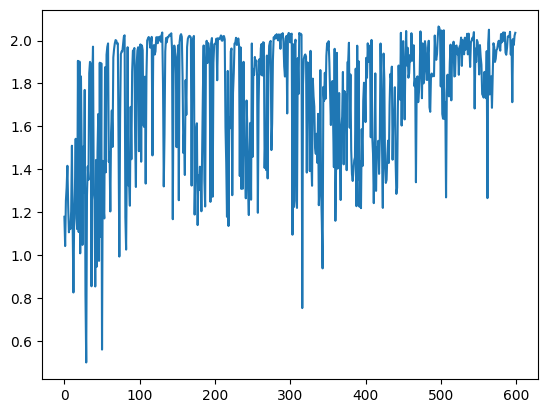

In [73]:
plt.plot(result_first)
# len(result_first)

In [102]:
test_architecture = AcesStepArchitectureEnv(24)
test_architecture.architecture.clusters

{0: [9, 10], 1: [3, 4], 2: [7, 8], 3: [0]}

In [75]:
# checkpoint_path = algorithm_first.save("./TFM/algorithms/10stations_600iter")

In [94]:
obs = test_architecture.reset()
test_architecture.architecture.round_robin()
print(test_architecture.architecture.compute_normalized_latency_dict())
print(test_architecture.architecture.compute_total_latency())
test_architecture.architecture.greedy_server()
print(test_architecture.architecture.compute_normalized_latency_dict())
print(test_architecture.architecture.compute_total_latency())
# test_architecture.architecture.greedy_algorithm()
# print(test_architecture.architecture.compute_normalized_latency_dict())
# print(test_architecture.architecture.compute_total_latency())
iteration = {}
allocation = []
type = []
for i in range(4):
    action = algorithm_first.compute_single_action(obs)
    output = test_architecture.step(action)
    obs = output[0]
    iteration[i] = output[1]
    if i==0:
        for i in range(12):
            allocation.append(action[i])
            type.append(0)
    elif i==1:
        for i in range(24):
            allocation.append(action[i])
            type.append(1)
    elif i==2:
        for i in range(24):
            allocation.append(action[i])
            type.append(2)
    else:
        for i in range(20):
            allocation.append(action[i])
            type.append(3)

# print(allocation)
# print(type)
test_architecture.architecture.false_data_allocation = allocation
test_architecture.architecture.false_data_types = type
test_architecture.architecture.false_construct_dictionaries()
print(iteration)
print(test_architecture.architecture.false_compute_total_latency())

{0: 0.3207547169811321, 1: 0.3188268684957427, 2: 0.3188268684957427, 3: 0.600907029478458}
2876
{0: 0.5018867924528302, 1: 0.5004730368968779, 2: 0.5004730368968779, 3: 0.7732426303854876}
2080
{0: 0.7056603773584906, 1: 0.41721854304635764, 2: 0.34153263954588453, 3: -1}
2424
